<a href="https://colab.research.google.com/github/violetcfelt/oceanfronts/blob/main/TrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Activation
from tensorflow.keras import Model

In [45]:
def custom_loss(logits, label):
    """
    Implements Equation [2] in https://arxiv.org/pdf/1504.06375.pdf
    """
    y = tf.cast(label, tf.float32)

    count_neg = tf.reduce_sum(1. - y)
    count_pos = tf.reduce_sum(y)

    beta = count_neg / (count_neg + count_pos)

    pos_weight = beta / (1 - beta)

    cost = tf.nn.weighted_cross_entropy_with_logits(logits=logits, labels=y, pos_weight=pos_weight)

    cost = tf.reduce_mean(cost * (1 - beta))

    return cost

def side_layer(inputs, upscale):
  side = Conv2D(filters=64*upscale, kernel_size=3, padding='SAME')(inputs)
  side = Conv2DTranspose(filters=2, kernel_size=3, strides=upscale, padding='SAME')(side)
  return side

def HED():

  inputs = Input(shape=(256,256,5))

  conv1_1 = Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu')(inputs)
  conv1_2 = Conv2D(filters=64, kernel_size=3, padding='SAME', activation='relu')(conv1_1)
  side_1 = side_layer(conv1_2, 1)
  pool_1 = MaxPool2D(pool_size=2, padding='SAME')(conv1_2)

  conv2_1 = Conv2D(filters=128, kernel_size=3, padding='SAME', activation='relu')(pool_1)
  conv2_2 = Conv2D(filters=128, kernel_size=3, padding='SAME', activation='relu')(conv2_1)
  side_2 = side_layer(conv2_2, 2)
  pool_2 = MaxPool2D(pool_size=2, padding='SAME')(conv2_2)

  conv3_1 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(pool_2)
  conv3_2 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(conv3_1)
  conv3_3 = Conv2D(filters=256, kernel_size=3, padding='SAME', activation='relu')(conv3_2)
  side_3 = side_layer(conv3_3, 4)
  pool_3 = MaxPool2D(pool_size=2, padding='SAME')(conv3_3)
  
  conv4_1 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(pool_3)
  conv4_2 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv4_1)
  conv4_3 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv4_2)
  side_4 = side_layer(conv4_3, 8)
  pool_4 = MaxPool2D(pool_size=2, padding='SAME')(conv4_3)

  conv5_1 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(pool_4)
  conv5_2 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv5_1)
  conv5_3 = Conv2D(filters=512, kernel_size=3, padding='SAME', activation='relu')(conv5_2)
  side_5 = side_layer(conv5_3, 16)

  side_outputs = [side_1, side_2, side_3, side_4, side_5]
  fuse = Conv2D(filters=2, kernel_size=3, padding='SAME')(tf.concat(side_outputs, axis=3))
  output = Activation('sigmoid')(fuse)
  # outputs = side_outputs + [fuse]

  model = Model(inputs=inputs, outputs=output)
  return model

In [46]:
model = HED()
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 256, 256, 64  2944        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_134 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_133[0][0]']             
                                )                                                           

In [47]:
model.compile(loss=custom_loss) #need the custom loss because of our weird output

In [48]:
from google.colab import drive
import glob
import numpy as np
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [49]:
scene_list = set()
for file in glob.glob("/content/drive/My Drive/east_training/*.npy"):
   scene_list.add(file.split('/')[-1].rsplit('_', 1)[0])

print(scene_list)
print(len(scene_list))

{'LC08_013033_20200222', 'LC08_011032_20180423', 'LC08_012032_20141113', 'LC08_012032_20171020', 'LC08_008030_20170415', 'LC08_013033_20170418', 'LC08_011032_20200311', 'LC08_011030_20211109', 'LC08_012032_20130502', 'LC08_016039_20130328', 'LC08_013033_20160330', 'LC08_011030_20151109', 'LC08_015037_20171025', 'LC08_012032_20140809', 'LC08_008030_20150325', 'LC08_015037_20131217', 'LC08_012032_20201129', 'LC08_013033_20160415', 'LC08_011030_20180423', 'LC08_012032_20210321', 'LC08_016039_20180309', 'LC08_011032_20211109', 'LC08_011030_20181016', 'LC08_008030_20180824', 'LC08_016038_20180309', 'LC08_012032_20160424', 'LC08_013035_20161024', 'LC08_011030_20210517', 'LC08_016038_20200126', 'LC08_015037_20141017', 'LC08_015037_20180302', 'LC08_011030_20160823', 'LC08_016038_20140517', 'LC08_013035_20131219', 'LC08_012032_20200318', 'LC08_013033_20140410', 'LC08_011030_20210330', 'LC08_011030_20180829', 'LC08_011032_20210226', 'LC08_011032_20200224', 'LC08_015037_20211020', 'LC08_013041_20

In [50]:
scene_list = list(scene_list)
X_train = np.empty((len(scene_list),256,256,5),dtype=np.float32)
Y_train = np.empty((len(scene_list),256,256,2),dtype=np.float32)
for scene_num in range(len(scene_list)):
  X_train[scene_num] = np.load('/content/drive/My Drive/east_training/' + scene_list[scene_num] + '_input.npy')
  Y_train[scene_num] = np.load('/content/drive/My Drive/east_training/' + scene_list[scene_num] + '_output.npy')

In [51]:
print(Y_train[0][5][0][0])

0.0


In [52]:
history = model.fit(X_train, Y_train, epochs=25)
model.save_weights('/content/drive/My Drive/trained_weights.h5')
print(history)

Epoch 1/25
2/2 [==============================] - 169s 50s/step - loss: 0.3473
Epoch 2/25
2/2 [==============================] - 134s 50s/step - loss: 0.2862
Epoch 3/25
2/2 [==============================] - 134s 50s/step - loss: 0.1251
Epoch 4/25
2/2 [==============================] - 134s 50s/step - loss: 0.0566
Epoch 5/25
2/2 [==============================] - 137s 53s/step - loss: 0.0070
Epoch 6/25
2/2 [==============================] - 133s 50s/step - loss: 0.0018
Epoch 7/25
2/2 [==============================] - 134s 50s/step - loss: 0.0245
Epoch 8/25
2/2 [==============================] - 134s 50s/step - loss: 7.7186e-04
Epoch 9/25
2/2 [==============================] - 133s 50s/step - loss: 2.9277e-04
Epoch 10/25
2/2 [==============================] - 137s 51s/step - loss: 1.3670e-04
Epoch 11/25
2/2 [==============================] - 135s 50s/step - loss: 6.9643e-05
Epoch 12/25
2/2 [==============================] - 135s 50s/step - loss: 3.6555e-05
Epoch 13/25
2/2 [============

In [21]:
print(history.params)

{'verbose': 1, 'epochs': 25, 'steps': 2}


In [54]:
print(history.history.keys())

dict_keys(['loss'])


In [53]:
print(history.history['loss'])

[0.3473142683506012, 0.2862316071987152, 0.12510384619235992, 0.0565720871090889, 0.006958435755223036, 0.0017931615002453327, 0.024494998157024384, 0.0007718628621660173, 0.00029277268913574517, 0.00013670283078681678, 6.964289786992595e-05, 3.6555305996444076e-05, 2.0765713998116553e-05, 1.4341530004458036e-05, 1.1488975360407494e-05, 9.549437891109847e-06, 8.025127499422524e-06, 6.748327905370388e-06, 5.735495960834669e-06, 4.892622200713959e-06, 4.203164735372411e-06, 3.6027115584147396e-06, 3.080547912759357e-06, 2.6755355975183193e-06, 2.342514562769793e-06]


Text(0.5, 1.0, 'Loss During Training')

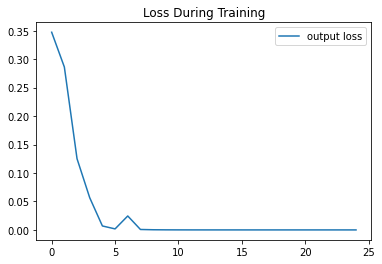

In [55]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label = 'output loss')
# plt.plot(history.history['conv2d_transpose_5_loss'], label = 'side loss 1')
# plt.plot(history.history['conv2d_transpose_6_loss'], label = 'side loss 2')
# plt.plot(history.history['conv2d_transpose_7_loss'], label = 'side loss 3')
# plt.plot(history.history['conv2d_transpose_8_loss'], label = 'side loss 4')
# plt.plot(history.history['conv2d_transpose_9_loss'], label = 'side loss 5')
plt.legend()
plt.title('Loss During Training')

Text(0.5, 1.0, 'Accuracy During Training')

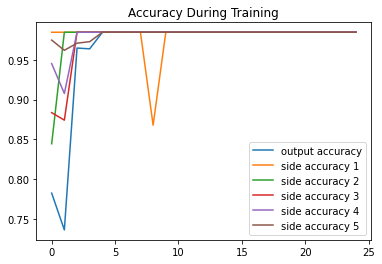

In [26]:
plt.plot(history.history['conv2d_37_binary_accuracy'], label = 'output accuracy')
plt.plot(history.history['conv2d_transpose_5_binary_accuracy'], label = 'side accuracy 1')
plt.plot(history.history['conv2d_transpose_6_binary_accuracy'], label = 'side accuracy 2')
plt.plot(history.history['conv2d_transpose_7_binary_accuracy'], label = 'side accuracy 3')
plt.plot(history.history['conv2d_transpose_8_binary_accuracy'], label = 'side accuracy 4')
plt.plot(history.history['conv2d_transpose_9_binary_accuracy'], label = 'side accuracy 5')
plt.legend()
plt.title('Accuracy During Training')